# Using Neural Networks on Two Simple Datasets

## Classification

In [1]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc3 as pm
import pickle
import theano
import theano.tensor as T
import os
import matplotlib
from sklearn.model_selection import train_test_split
import seaborn as sns
plt.style.use('seaborn')
sns.set_context("poster",font_scale=1)
%matplotlib inline

### Creating the data and the initial plot of the whole set

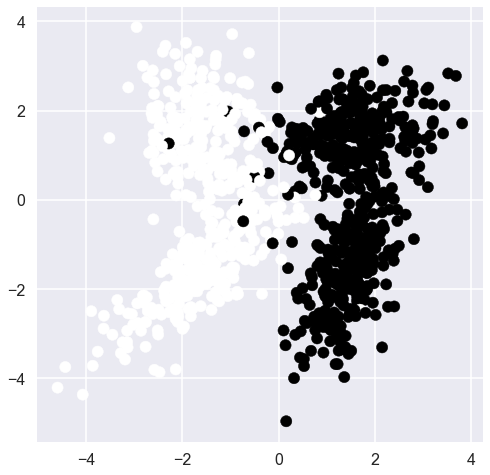

In [770]:
if os.path.exists("class_data2"):
    with open("class_data2","rb") as f:
        data = pickle.load(f)
else:
    data = make_classification(n_samples=1000,n_features=2,n_redundant=0, class_sep=1.5, n_clusters_per_class=2)

X = data[0]
y = data[1]

df = pd.DataFrame(X)
plt.figure(figsize=(8,8))
plt.scatter(df[0], df[1], c=y)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Creating a neural network model and sampling from the distribution

In [2]:
ann_input = theano.shared(X_train)
ann_output = theano.shared(y_train)

N=1000
n_units = 10

init_in_1 = np.random.randn(X.shape[1], n_units)
init_1_2 = np.random.randn(n_units, n_units)
init_2_out = np.random.randn(n_units, 1)
mlc = pm.Model()
with mlc: 
    w_in_1 = pm.Normal("w_in_1", 0, 1, shape=(X.shape[1], n_units), testval=init_in_1)
    w_1_2 = pm.Normal("w_1_2", 0, 1, shape=(n_units, n_units), testval=init_1_2)
    w_2_out = pm.Normal("w_2_out", 0, 1, shape=(n_units, 1), testval=init_2_out)
    
    act_1 = T.tanh(T.dot(ann_input, 
                         w_in_1))
    act_2 = T.tanh(T.dot(act_1, 
                         w_1_2))
    act_out = T.nnet.sigmoid(T.dot(act_2, 
                                   w_2_out))
    
    # Binary classification -> Bernoulli likelihood
    out = pm.Bernoulli('out', 
                       act_out.flatten(),
                       observed=ann_output)

    step = pm.NUTS()
    trace = pm.sample(N, step=step)

NameError: name 'X_train' is not defined

### Creating posterior predictive check samples

In [51]:
# Replace shared variables with testing set
ann_input.set_value(X_test)
ann_output.set_value(y_test)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=mlc, samples=500)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

100%|██████████| 500/500 [00:00<00:00, 1903.95it/s]


### Plotting the results

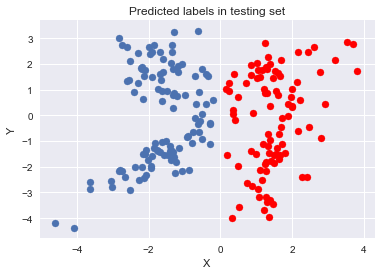

In [53]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y',);

## Regression

### Creating the data and the initial plot of the whole set

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [noise, x_interval__]
100%|██████████| 1000/1000 [00:02<00:00, 472.80it/s]


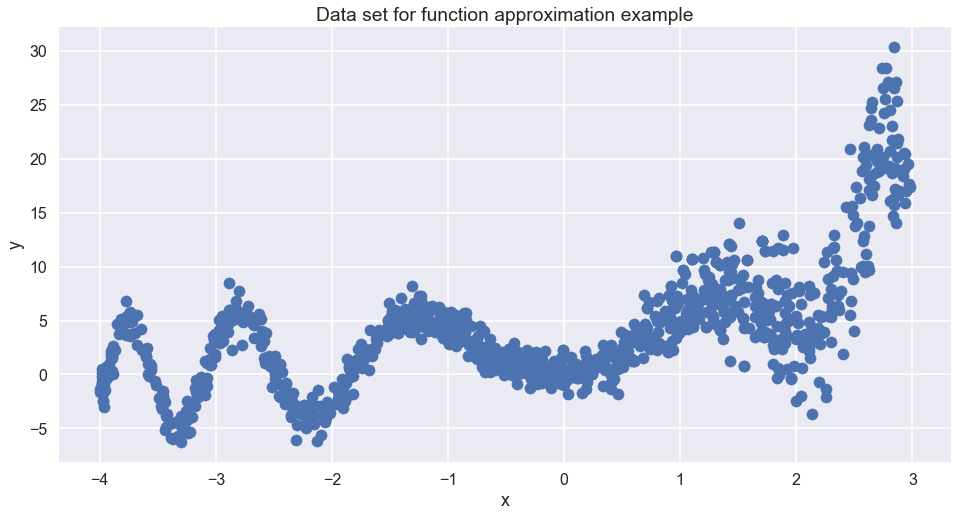

In [4]:
if os.path.exists("reg_data-"):
    with open("reg_data","rb") as f:
        data = pickle.load(f)
else:
    m = pm.Model()
    lower=-4
    upper=3
    with m:
        x = pm.Uniform("x", lower=lower, upper=upper, testval=0.1)
        noise = pm.Normal("noise", mu=0, sd=1+(x>0.1)*abs(x)*1.2, testval=0.1)
        #noise = pm.Normal("noise", mu=0, sd=1+np.sqrt(4-np.abs(x))**2, testval=0.1)
        y = pm.Deterministic("y", 5*np.sin(x**2)+ x ** 2 + (x ** 3)/(2*np.sqrt(abs(x))) + x/5 + noise)
        trace = pm.sample(500)
    X = trace.get_values("x")
    y = trace.get_values("y")

    data = [X, y]
    with open("reg_data-","wb") as f:
        pickle.dump(data, f)

X, y = data
        
plt.figure(figsize=(16,8))
plt.title("Data set for function approximation example")
plt.ylabel("y")
plt.xlabel("x")
plt.scatter(X ,y)

In [5]:
def plot_ppc(X, y, algorithm, ppc, n_lines=500, pred=True, scatter=True):
    all_data = ppc["out"]
    idx = np.random.choice(range(all_data.shape[0]), size=n_lines, replace=False)
    plt.figure(figsize=(16,8))
    
    for i in idx:
        data = np.array([X_test[:,0], all_data[i,:]]).transpose()
        data = data[data[:,0].argsort()]
        plt.plot(data[:,0], data[:,1], alpha=0.01, c="r")
    if pred:
        pred = all_data.mean(axis=0)
        data = np.array([X_test[:,0], pred]).transpose()
        data = data[data[:,0].argsort()]
        plt.plot(data[:,0], data[:,1], c="r", lw=3)
    if scatter:
        plt.scatter(X[:,0],y)
    
    plt.title("Neural network regression with {} sampling".format(algorithm))
    plt.ylabel("y")    
    plt.xlabel("x")    

### Creating and sampling from the neural network model

In [6]:
X = pd.DataFrame(X)
X["1"] = 1
X = X.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [43]:
N=100000
n_units=5

init_in_1 = np.random.randn(X.shape[1], n_units)
init_1_2 = np.random.randn(n_units + 1, n_units)
init_2_out = np.random.randn(n_units + 1, 1)

### MHMCMC

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
100%|██████████| 500/500 [00:00<00:00, 960.30it/s]


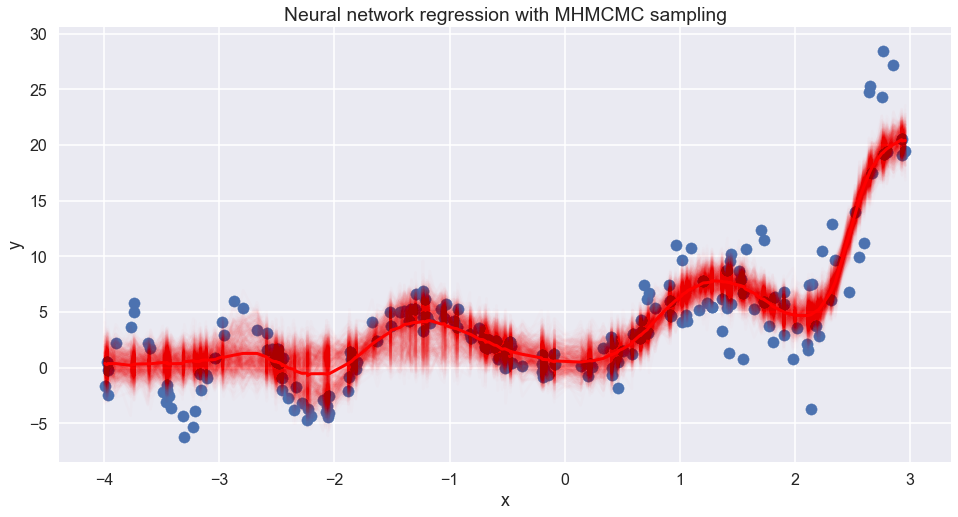

In [44]:
ann_input = theano.shared(X_train)
#ann_input = theano.shared(np.reshape(X_train, (len(X_train),1)))
ann_output = theano.shared(y_train)

mlc = pm.Model()
with mlc: 
    w_in_1 = pm.Normal("w_in_1", 0, 1, shape=(X.shape[1], n_units), testval=init_in_1)
    w_1_2 = pm.Normal("w_1_2", 0, 1, shape=(n_units + 1, n_units), testval=init_1_2)
    w_2_out = pm.Normal("w_2_out", 0, 1, shape=(n_units + 1, 1), testval=init_2_out)

    act_1 = T.nnet.sigmoid(T.dot(ann_input, w_in_1))
    act_1 = T.concatenate((act_1,T.ones((ann_input.shape[0],1))),axis=1)                          
    act_2 = T.nnet.sigmoid(T.dot(act_1, w_1_2))
    act_2 = T.concatenate((act_2,T.ones((act_1.shape[0],1))),axis=1)    
    act_out = T.dot(act_2,w_2_out)
    out = pm.Normal('out', act_out.flatten(), observed=ann_output)   
    
    step=pm.Metropolis()
    trace = pm.sample(N, step=step)
    
ann_input.set_value(X_test)
ann_output.set_value(y_test)
ppc=pm.sample_ppc(trace, model=mlc, samples=500)

plot_ppc(X_test, y_test, "MHMCMC", ppc, n_lines=500)

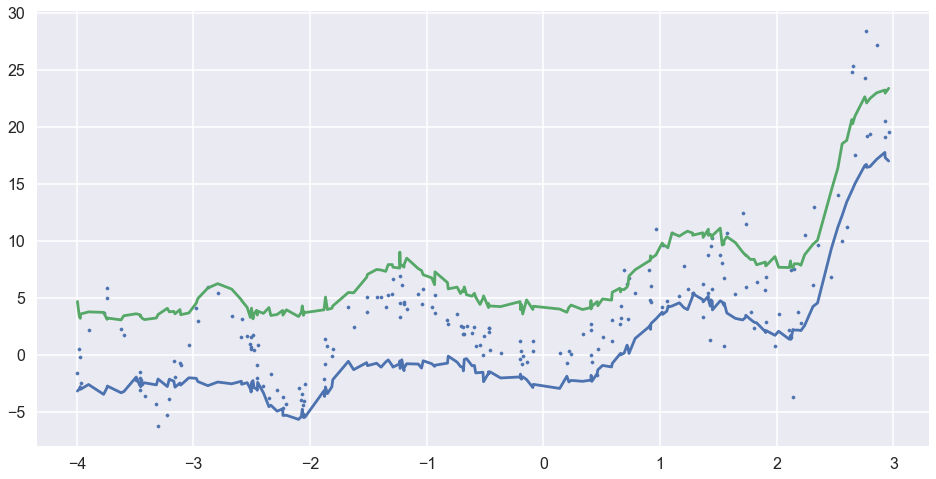

In [45]:
plt.figure(figsize=(16,8))
percentiles = np.percentile(ppc["out"], [0.1, 99.9], axis=0)
plt.scatter(X_test[:,0],y_test, s=10)
data = np.array([X_test[:,0], percentiles[0]]).transpose()
data = data[data[:,0].argsort()]
plt.plot(data[:,0], data[:,1])

data = np.array([X_test[:,0], percentiles[1]]).transpose()
data = data[data[:,0].argsort()]
plt.plot(data[:,0], data[:,1])

In [19]:
ppc["out"].mean(axis=0).shape

(200,)

In [13]:
ppc["out"].percentile([.05, .95], axis=1)

AttributeError: 'numpy.ndarray' object has no attribute 'percentile'

In [747]:
summary_mh = pm.stats.summary(trace)

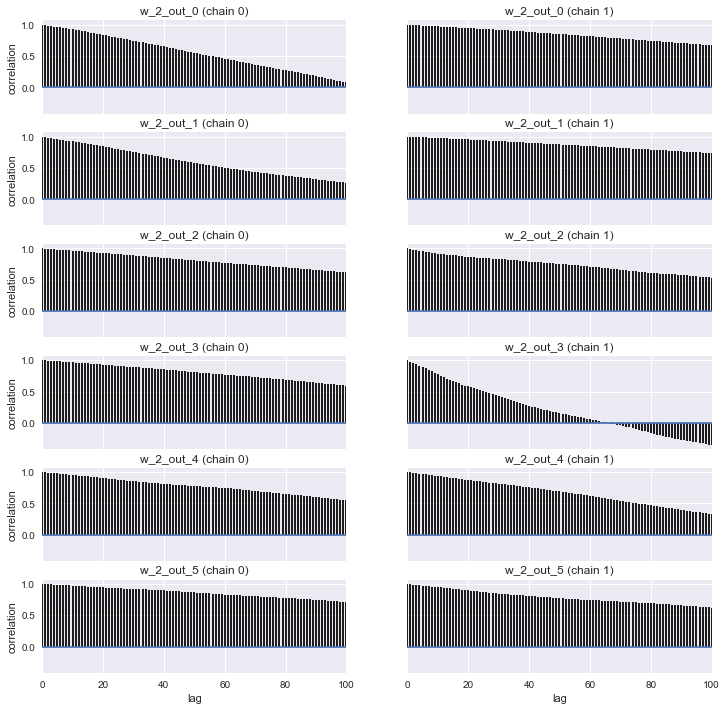

In [750]:
_ = pm.plots.autocorrplot(trace, varnames=["w_2_out"])

### HMC-NUTS

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w_2_out, w_1_2, w_in_1]
 94%|█████████▍| 1417/1500 [04:13<00:18,  4.41it/s]/usr/local/lib/python3.5/dist-packages/pymc3-3.2-py3.5.egg/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 500/500 [00:00<00:00, 1602.52it/s]


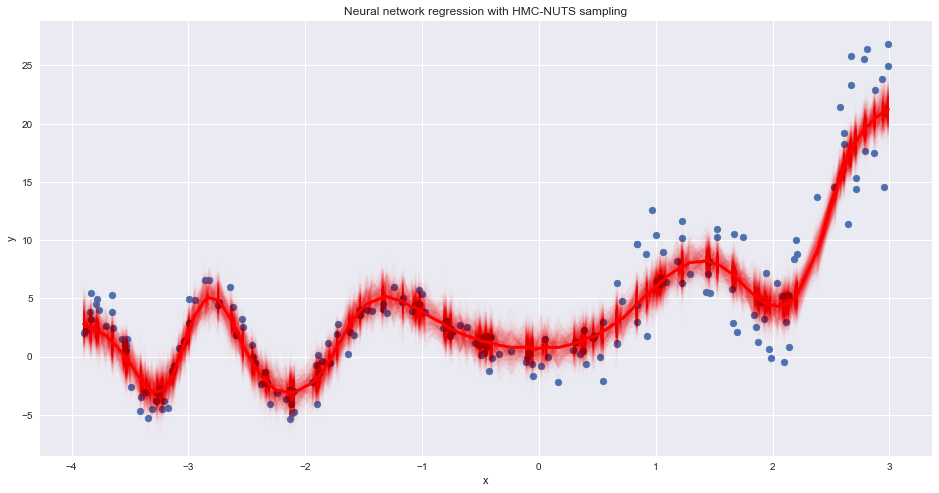

In [751]:
ann_input = theano.shared(X_train)
#ann_input = theano.shared(np.reshape(X_train, (len(X_train),1)))
ann_output = theano.shared(y_train)

mlc = pm.Model()
with mlc: 
    w_in_1 = pm.Normal("w_in_1", 0, 1, shape=(X.shape[1], n_units), testval=init_in_1)
    w_1_2 = pm.Normal("w_1_2", 0, 1, shape=(n_units + 1, n_units), testval=init_1_2)
    w_2_out = pm.Normal("w_2_out", 0, 1, shape=(n_units + 1, 1), testval=init_2_out)

    act_1 = T.nnet.sigmoid(T.dot(ann_input, w_in_1))
    act_1 = T.concatenate((act_1,T.ones((ann_input.shape[0],1))),axis=1)                          
    act_2 = T.nnet.sigmoid(T.dot(act_1, w_1_2))
    act_2 = T.concatenate((act_2,T.ones((act_1.shape[0],1))),axis=1)    
    act_out = T.dot(act_2,w_2_out)
    out = pm.Normal('out', act_out.flatten(), observed=ann_output)   
    
    step=pm.NUTS()
    trace = pm.sample(N, step=step)
    
ann_input.set_value(X_test)
ann_output.set_value(y_test)
ppc=pm.sample_ppc(trace, model=mlc, samples=500)

plot_ppc(X_test, y_test, "HMC-NUTS", ppc, n_lines=500)

In [752]:
summary_hmc = pm.stats.summary(trace)

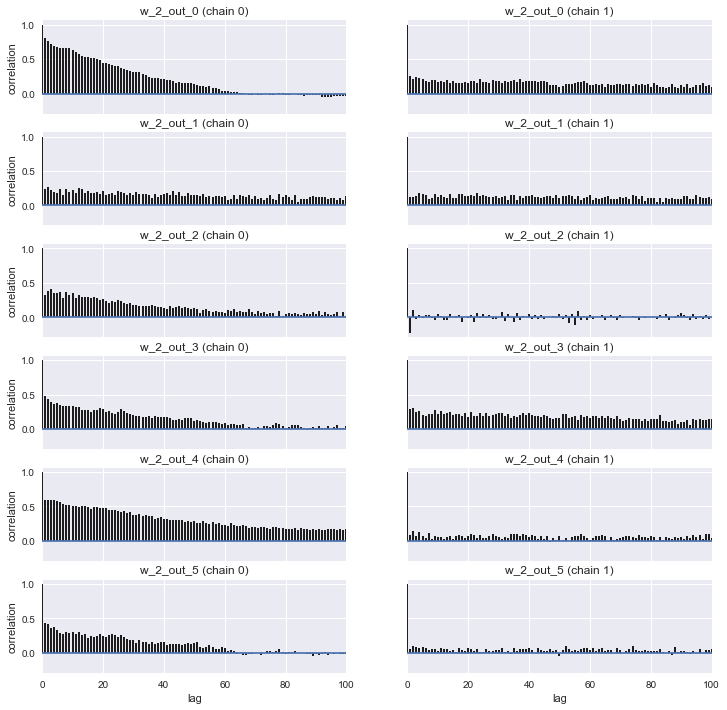

In [753]:
_ = pm.plots.autocorrplot(trace, varnames=["w_2_out"])

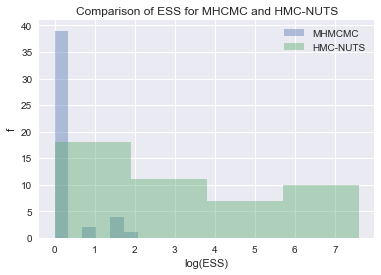

In [768]:
sns.distplot(np.log(summary_mh["n_eff"]), kde=False, label="MHMCMC")
sns.distplot(np.log(summary_hmc["n_eff"]), kde=False, label="HMC-NUTS")
_ = plt.legend()
_ = plt.title("Comparison of ESS for MHCMC and HMC-NUTS")
_ = plt.ylabel("f")
_ = plt.xlabel("log(ESS)")

### Outtakes

In [ ]:
def conduct_mlp_regressor(X_train, y_train, N, step, n_units=5):
    ann_input = theano.shared(X_train)
    #ann_input = theano.shared(np.reshape(X_train, (len(X_train),1)))
    ann_output = theano.shared(y_train)

    init_in_1 = np.random.randn(X.shape[1], n_units)
    init_1_2 = np.random.randn(n_units + 1, n_units)
    init_2_out = np.random.randn(n_units + 1, 1)
    mlc = pm.Model()
    with mlc: 
        w_in_1 = pm.Normal("w_in_1", 0, 1, shape=(X.shape[1], n_units), testval=init_in_1)
        w_1_2 = pm.Normal("w_1_2", 0, 1, shape=(n_units + 1, n_units), testval=init_1_2)
        w_2_out = pm.Normal("w_2_out", 0, 1, shape=(n_units + 1, 1), testval=init_2_out)

        act_1 = T.nnet.sigmoid(T.dot(ann_input, w_in_1))
        act_1 = T.concatenate((act_1,T.ones((ann_input.shape[0],1))),axis=1)                          
        act_2 = T.nnet.sigmoid(T.dot(act_1, w_1_2))
        act_2 = T.concatenate((act_2,T.ones((act_1.shape[0],1))),axis=1)    
        act_out = T.dot(act_2,w_2_out)
        out = pm.Normal('out', act_out.flatten(), observed=ann_output)
        if step=="mh":
            step = pm.Metropolis()
        elif step=="nuts":
            step = pm.NUTS()
        
        
        trace = pm.sample(N, step=step)
    return mlc, trace

In [ ]:
        #y = pm.Deterministic("y", x * 2 + noise)
        #y = pm.Deterministic("y", x ** 2 + noise)
        #y = pm.Deterministic("y", 5*np.sin(x**2)+ x ** 2 + (x ** 3)/np.sqrt(abs(x)) + x/5 + noise)